In [2]:
import sim_modules as sm
import numpy as np
import matplotlib.pyplot  as plt
import sys 
import input as input 
import os
import random

size= input.size
pathin= input.pathin
pathout=input.pathout
cols = 2*size
print('Sim Directory is %s'%input.pathin)
print('reading from ', input.num_participants, 'participants', input.steps, 'timesteps', input.ampContemp, input.ampLagged, input.ampMeasure, input.maskZero)
printpath=pathout+'sims/numParticipants_%s'%input.num_participants
print('Main dir is %s'%printpath)

Sim Directory is /Users/mac/Desktop/CIFAR/220429.FinalMatrices
reading from  10 participants 100 timesteps 0.01 0.01 1.0 True
Main dir is /Users/mac/Desktop/CIFAR/220429.FinalMatrices_Pythonsims/numParticipants_10


In [18]:
plt.close()
savepath=pathout+'sims/numParticipants_%s/steps_%s/Contemp_%s_amp_%s/Lagged_%s_amp_%s/Measure_%s_amp_%s/mask_%s/clipsigma_%s/'%(input.num_participants,str(input.steps),input.covContempName,str(input.ampContemp),input.covLaggedName, str(input.ampLagged),input.measurecovName, str(input.ampMeasure),str(input.maskZero),str(input.clip_sigma))
try:
    os.makedirs(savepath)
    if input.debug:
        print('making %s'%savepath)
except:
    if input.debug:
        print('directory %s exists'%savepath)
    pass
if input.clip_outliers:
    if input.debug:
        print('Making clip/preclip dirs')
    savepathprecliporig=os.path.join(savepath,'preclip/')
    try:
        os.mkdir(savepathprecliporig)
    except:
        if input.debug:
            print('preclip dir exists')
    
    savepathcliporig=os.path.join(savepath,'clip/')
    try:
        os.mkdir(savepathcliporig)
    except:
        if input.debug:
            print('clip dir exists')

for j in range(input.num_iterations):
    # Set random seed for each individual
    random.seed(123 + j)
            
    if input.debug:
        print('making rep dirs')
    savepathclip=os.path.join(savepathcliporig,'rep_%i/'%j)
    savepathpreclip=os.path.join(savepathprecliporig,'rep_%i/'%j)
    try:
        os.mkdir(savepathclip)
        os.mkdir(savepathpreclip)
    except:
        print(f'rep dir {j} exists')
    #vec = [97, 68, 6, 40, 41, 7, 69, 96, 94, 43, 5, 4, 42, 95, 91, 1, 92, 3, 45, 44, 2, 93, 122, 37, 36, 123, 121, 135, 34, 35, 134, 124, 130, 31, 131, 125, 133, 127, 32, 33, 126, 132, 103, 102, 100, 128, 15, 14, 129, 101, 105, 10, 38, 39, 11, 104, 13, 12, 75, 61, 74, 62, 63, 98, 67, 73, 9, 8, 72, 66, 99, 70, 64, 65, 71]
    for number in range(input.num_participants):
    #for number in vec:
        
        csvnum = number+1
     #   csvnum = number
        if input.debug:
            print('Writing sims for participant %i and sim iteration %i'%(csvnum,j))
        #file = pathin+'ind_%i.csv'%csvnum
        file = pathin+'/%i.csv'%csvnum
        data = np.loadtxt(file, skiprows=1, usecols=range(0,cols), delimiter=',')
        matContemp = data[:,size:] #same day (contemporaneous) beta values
        matLagged = data[:,:size] #lagged beta values
        
        # sm.save_matrix(matContemp, 'matContempOrig.csv')
        # sm.save_matrix(matLagged, 'matLaggedOrig.csv')
        # sm.plot_matrix(matLagged, True, 'matLaggedOrig.png')
        # sm.plot_matrix(matContemp, True, 'matContempOrig.png')
        
        if input.covContempName=='randn':
            covContemp = np.random.randn(size,size)
        else:
            covContemp = np.ones(size)

        if input.covLaggedName=='randn':
            covLagged = np.random.randn(size,size)
        else:
            covLagged =np.ones(size)

        if input.measurecovName=='diag':
            measureCov= input.ampMeasure*np.eye(size)
        
        if input.maskZero:
            maskContemp =  sm.make_mask(matContemp, contemp=True)
            maskLagged = sm.make_mask(matLagged, contemp=False)

            ## If assuming only diagonal lagged entries
            #sm.plot_matrix(maskLagged, True, 'maskLagged_before.png')
            #maskLaggedDiag = np.eye(input.size)
            #maskLagged=maskLagged*maskLaggedDiag
            #sm.plot_matrix(maskLagged, True, 'maskLagged_after.png')

        else:
            maskContemp =  np.ones((input.size, input.size))
            np.fill_diagonal(maskContemp,0) # still make diagonal zeros
            maskLagged = np.ones((input.size, input.size))

            
        #sm.plot_matrix(maskLagged, True, 'maskLagged.png')
        # sm.plot_matrix(maskContemp, True, 'maskContemp.png')
        plt.close()
        samples = sm.generate_timeseries(input.start, input.steps, input.ampContemp, matContemp, covContemp, input.ampLagged, matLagged, covLagged,measureCov,input.save)
        
        
        if input.debug:
            print(np.sqrt(np.diagonal(measureCov)[0])*3, 'max')
            for p in range(np.shape(samples)[1]):

                inds_pre = np.where(samples[:,p]>np.sqrt(np.diagonal(measureCov)[0])*3)[0]
                print(inds_pre, samples[inds_pre,p],p)
            print('---- TEST pre clip -----')
        if input.clip_samples:
        # Checking the clipping
            samples_clip = sm.clip_timeseries(samples, input.clip_indices, input.clip_mins, input.clip_maxs)
            samples=samples_clip
            if input.debug:
                print('saved clip')
        
        if input.clip_outliers:
            if input.debug:
                print('Clipping samples if needed')
            
            savefile = savepathpreclip+'ind_%i_preclip.txt'%(csvnum)
            np.savetxt(savefile,samples, delimiter=',')
            samples_clip = sm.clip_outliers(samples, input.clip_sigma,input.ampMeasure, input.debug,input.start, input.ampContemp, matContemp, covContemp, input.ampLagged, matLagged, covLagged,measureCov)
            samples=samples_clip.copy()
            if input.debug:
                for p in range(np.shape(samples)[1]):
                    inds_post = np.where(samples[:,p]>np.sqrt(np.diagonal(measureCov)[0])*3)[0]
                    print(inds_post,samples[inds_post,p],p)

                print('---- TEST post clip -----')
            if input.debug:
                print('saved clip')
            savefile = savepathclip+'ind_%i.txt'%(csvnum)
        
        np.savetxt(savefile,samples, delimiter=',')

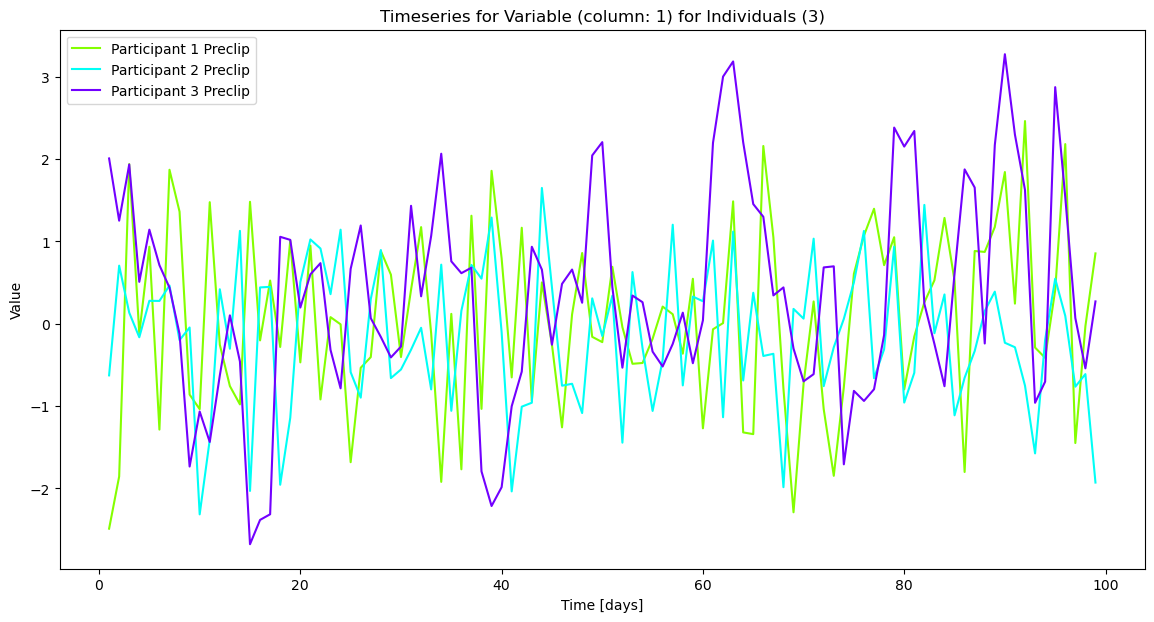

In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure you have seaborn installed by running: pip install seaborn

def construct_filepath(base_path, num_participants, steps, contemp_type, contemp_amp, lagged_type, lagged_amp, measure_type, measure_amp, mask, clipsigma, participant_number, iteration, preclipped=False):
    # Build the directory path with the correct separators between configurations and values
    directory = os.path.join(
        f"numParticipants_{num_participants}",
        f"steps_{steps}",
        f"{contemp_type}_amp_{contemp_amp}",
        f"{lagged_type}_amp_{lagged_amp}",
        f"{measure_type}_amp_{measure_amp}",
        f"mask_{'TRUE' if mask else 'FALSE'}",
        f"clipsigma_{clipsigma}"
    )
    
    # Choose the correct subfolder based on whether the data is preclipped or clipped
    subfolder = "preclip" if preclipped else "clip"
    
    # Construct the full file path using the base path and all directory components
    folder = os.path.join(base_path, directory, subfolder, f"rep_{iteration}")
    
    # Define the filename depending on whether it is preclipped or clipped data
    filename_suffix = "_preclip" if preclipped else ""
    filename = f"ind_{participant_number}{filename_suffix}.txt"
    
    # Combine the folder path and filename into the full file path
    full_path = os.path.join(folder, filename)
    #print(f"Constructed file path: {full_path}")  # Debugging line
    return full_path

def plot_timeseries(base_path, num_participants, steps, contemp_type, contemp_amp, lagged_type, lagged_amp, measure_type, measure_amp, mask, clipsigma, column, iterations, participant_numbers, show_preclip=True, show_clip=True):
    plt.figure(figsize=(14, 7))
    sns.set_palette("hsv", n_colors=len(participant_numbers))  # Set a color palette
    
    for iteration in iterations:
        for participant_number in participant_numbers:
            # Construct file paths for preclipped and clipped data
            preclip_path = construct_filepath(base_path, num_participants, steps, contemp_type, contemp_amp, lagged_type, lagged_amp, measure_type, measure_amp, mask, clipsigma, participant_number, iteration, preclipped=True)
            clip_path = construct_filepath(base_path, num_participants, steps, contemp_type, contemp_amp, lagged_type, lagged_amp, measure_type, measure_amp, mask, clipsigma, participant_number, iteration, preclipped=False)
            
            # Read and plot the pre-clipped data
            if show_preclip and os.path.exists(preclip_path):
                preclip_data = pd.read_csv(preclip_path, header=None)
                if not preclip_data.empty:
                    plt.plot(np.arange(1, len(preclip_data) + 1), preclip_data[column - 1], label=f'Participant {participant_number} Preclip', linestyle='solid')
                else:
                    print(f"No data found in file: {preclip_path}")
            
            # Read and plot the clipped data
            if show_clip and os.path.exists(clip_path):
                clip_data = pd.read_csv(clip_path, header=None)
                if not clip_data.empty:
                    plt.plot(np.arange(1, len(clip_data) + 1), clip_data[column - 1], label=f'Participant {participant_number} Clip', linestyle='dotted')
                else:
                    print(f"No data found in file: {clip_path}")
    
    plt.xlabel("Time [days]")
    plt.ylabel("Value")
    plt.title(f"Timeseries for Variable (column: {column}) for Individuals ({len(participant_numbers)})")
    plt.legend()
    plt.show()

# Example usage
# Example usage
base_path = "/Users/mac/Desktop/CIFAR/220429.FinalMatrices_Pythonsims"  # Update this to your base path
num_participants = 10
steps = 100
contemp_type = "Contemp_randn"
contemp_amp = 0.01
lagged_type = "Lagged_randn"
lagged_amp = 0.01
measure_type = "Measure_diag"
measure_amp = 1.0
mask = True
clipsigma = 3
column = 1
iterations = [0]  # Specify the iterations you want to plot
participant_numbers = list(range(1, 4))  # Specify the participant numbers

# Plot the timeseries for the specified column
plot_timeseries(base_path, num_participants, steps, contemp_type, contemp_amp, lagged_type, lagged_amp, measure_type, measure_amp, mask, clipsigma, column, iterations, participant_numbers, show_preclip=True, show_clip=False)
